## 0.Import libraries

In [1]:
import pandas as pd
import os, sys
import numpy as np
from dataclasses import dataclass
import random, math, operator
from pprint import pprint
import pickle, gc, itertools
from pathlib import Path
import time, datetime
from collections import *
import matplotlib.pyplot as plt
import subprocess
import gc

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from keras.layers import LSTM
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model

import warnings

## 1.Setup configuration

In [2]:
from requests import get
#colab_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
colab_filename = 'FxBERT_downstream_readFromRawData.ipynb'
result_filename = colab_filename.replace('.ipynb', '.csv')
result_filename

'FxBERT_downstream_readFromRawData.csv'

In [3]:
@dataclass
class Config:
    BATCH_SIZE = 1024
    EMBED_DIM = 128
    NUM_HEAD = 8  # used in bert model
    FF_DIM = 1024  # used in bert model
    NUM_LAYERS = 12
    EPOCH = 3 # 10000
    SEQLENGTH = 100
    CURRENCY ='USD_JPY_M15'
    MASK_PERCT = 0.15
    maxlen = 100
    patience = 30
    seqlen = 10
    isTrain = True

config = Config()

In [4]:
from google.colab import drive
drive.mount('/content/drive')
base_folder = '/content/drive/MyDrive/MyResearch_FT/14.BERT/'

gd_processedData_folder = base_folder + '3.processed_data'
gd_ref_folder = base_folder + '4.ref_data/'
gd_mdl_folder = base_folder + '1.model/FxBERT/'+config.CURRENCY+'/downstream/'
gd_result_folder = base_folder + '2.result/FxBERT/'
gd_rawdata_folder = base_folder + '5.raw_data/'

Mounted at /content/drive


In [ ]:
Path(gd_processedData_folder).mkdir(parents=True, exist_ok=True)
Path(gd_ref_folder).mkdir(parents=True, exist_ok=True)
Path(gd_mdl_folder).mkdir(parents=True, exist_ok=True)
Path(gd_result_folder).mkdir(parents=True, exist_ok=True)
# Path(gd_rawdata_folder).mkdir(parents=True, exist_ok=True)

## 2.FxBERT - create model

In [5]:
def bert_module(query, key, value, i, pad_mask=None):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}/multiheadattention".format(i),
    )(query, key, value, attention_mask=pad_mask)
    attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}/ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}/ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/ffn_layernormalization".format(i)
    )(attention_output + ffn_output)

    return sequence_output

def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

def get_attn_pad_mask(seq_q, seq_k):
   batch_size, len_q = seq_q.get_shape()
   batch_size, len_k = seq_k.get_shape()
   # eq(zero) is PAD token
   pad_attn_mask = tf.equal(seq_k, 0)
   pad_attn_mask = tf.expand_dims(pad_attn_mask, 1)  # batch_size x 1 x len_k(=len_q), one is masking
   pad_attn_mask = tf.repeat(pad_attn_mask, repeats=[len_q], axis=1)
   return pad_attn_mask  # batch_size x len_q x len_k

In [6]:
def unpickleData(file):
    print("start processing data ...")
    data_dict = {}

    if not os.path.isfile(file):
        print(file, "does not exist.")
    else:
        print(file, "... unpacking ...")
        with open(file, "rb") as fp:
            unpickler = pickle.Unpickler(fp)
            try:
                data_dict.update(unpickler.load())
            except:
                pass
            fp.close()

    print("len(data_dict)", len(data_dict))
    return data_dict

refData = unpickleData(os.path.join(gd_ref_folder, config.CURRENCY+'_dictionary_github.txt'))

start processing data ...
/content/drive/MyDrive/MyResearch_FT/14.BERT/4.ref_data/USD_JPY_M15_dictionary_github.txt ... unpacking ...
len(data_dict) 8


In [7]:
candlestick_vocab_size=len(refData['candlestick_encode_dict'])  # 39083
pos_vocab_size=len(refData['pos_decode_dict'])  # 6109
direction_vocab_size=len(refData['direction_encode_dict'])   # 7
candlepiece_vocab_size=len(refData['candlepiece_encode_dict'])   # 138
segment_size=3

In [8]:
def create_FxBERT(maxlen):
    input_wtoken_candle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_candle')
    input_wtoken_pos = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_pos')
    input_wtoken_die = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_die')
    input_wtoken_cle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_cle')
    input_wtoken_ule = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_ule')
    input_wtoken_lle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_lle')

    input_segment = layers.Input((maxlen,), dtype=tf.int64, name='segment_ids')

    wtoken_candle_embeddings = layers.Embedding(candlestick_vocab_size, config.EMBED_DIM, name='wtoken_candle_embedding')(input_wtoken_candle)
    wtoken_pos_embeddings = layers.Embedding(pos_vocab_size, config.EMBED_DIM, name='wtoken_embedding')(input_wtoken_pos)
    wtoken_die_embeddings = layers.Embedding(direction_vocab_size, config.EMBED_DIM, name='direction_embedding')(input_wtoken_die)
    wtoken_cle_embeddings = layers.Embedding(candlepiece_vocab_size, config.EMBED_DIM, name='candlelen_embedding')(input_wtoken_cle)
    wtoken_ule_embeddings = layers.Embedding(candlepiece_vocab_size, config.EMBED_DIM, name='upperlen_embedding')(input_wtoken_ule)
    wtoken_lle_embeddings = layers.Embedding(candlepiece_vocab_size, config.EMBED_DIM, name='lowerlen_embedding')(input_wtoken_lle)

    segment_embeddings = layers.Embedding(segment_size, config.EMBED_DIM, name='segment_embedding')(input_segment)

    mask = layers.Embedding(candlestick_vocab_size, config.EMBED_DIM, mask_zero=True).compute_mask(input_wtoken_candle)
    attn_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")

    position_embeddings = layers.Embedding(
        input_dim=maxlen,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(maxlen, config.EMBED_DIM)],
        name="position_embedding")(tf.range(start=0, limit=maxlen, delta=1))

    embeddings = wtoken_candle_embeddings + wtoken_pos_embeddings + position_embeddings + segment_embeddings + \
                    wtoken_die_embeddings + wtoken_cle_embeddings + wtoken_ule_embeddings + wtoken_lle_embeddings

    encoder_input = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_input, encoder_input, encoder_input, i, attn_mask)

    output_wtoken_candle = layers.Dense(candlestick_vocab_size, name='out_input_ids_candle', activation='softmax')(encoder_output)
    output_wtoken_pos = layers.Dense(pos_vocab_size, name='out_input_ids_pos', activation='softmax')(encoder_output)
    output_wtoken_die = layers.Dense(direction_vocab_size, name='out_input_ids_die', activation='softmax')(encoder_output)
    output_wtoken_cle = layers.Dense(candlepiece_vocab_size, name='out_input_ids_cle', activation='softmax')(encoder_output)
    output_wtoken_ule = layers.Dense(candlepiece_vocab_size, name='out_input_ids_ule', activation='softmax')(encoder_output)
    output_wtoken_lle = layers.Dense(candlepiece_vocab_size, name='out_input_ids_lle', activation='softmax')(encoder_output)

    flat_encoder_output = layers.Flatten(name="flat_encoder_output")(encoder_output)
    output_label_isNext = layers.Dense(2, name='label_isNext', activation='softmax')(flat_encoder_output)

    model = tf.keras.Model(
                            inputs=[input_wtoken_candle, input_wtoken_pos, input_wtoken_die, input_wtoken_cle,
                                    input_wtoken_ule, input_wtoken_lle, input_segment],
                            outputs=[output_wtoken_candle, output_wtoken_pos, output_wtoken_die, output_wtoken_cle,
                                     output_wtoken_ule, output_wtoken_lle, output_label_isNext],
                            name='FxBERT')

    return model

## 3.Evaluation functions

### 3.1 Prediction

In [43]:
def get_predictions_all(mdl, test_dataset):
    y_pred_maxprice, y_pred_minprice, y_pred_labelbhs = [], [], []
    y_true_maxprice, y_true_minprice, y_true_labelbhs = [], [], []
    ref_max_scale, ref_min_scale, maxprice_ori, minprice_ori = [], [], [], []

    df_prediction = pd.DataFrame(columns=['y_true_labelbhs', 'y_pred_labelbhs', 'y_true_maxprice', 'y_pred_maxprice', 'maxprice_ori', \
                                          'y_true_minprice', 'y_pred_minprice', 'minprice_ori', 'ref_max_scale', 'ref_min_scale'])

    test_inputs = test_dataset[0]
    test_targets = test_dataset[1]
    ref_data = test_dataset[2]

    prediction_maxprice = [item for sublist in mdl.predict(test_inputs)[0].tolist() for item in sublist]
    prediction_minprice = [item for sublist in mdl.predict(test_inputs)[1].tolist() for item in sublist]
    prediction_labelbhs = mdl.predict(test_inputs)[2].argmax(axis=-1).tolist()

    y_pred_maxprice.extend(prediction_maxprice)
    y_true_maxprice.extend(test_targets['max_price'])

    y_pred_minprice.extend(prediction_minprice)
    y_true_minprice.extend(test_targets['min_price'])

    y_pred_labelbhs.extend(prediction_labelbhs)
    y_true_labelbhs.extend(test_targets['label_bhs'])

    ref_max_scale.extend(ref_data['max_scale'])
    ref_min_scale.extend(ref_data['min_scale'])
    maxprice_ori.extend(ref_data['max_ori'])
    minprice_ori.extend(ref_data['min_ori'])

    df_prediction['y_true_labelbhs'],  df_prediction['y_pred_labelbhs'] = y_true_labelbhs, y_pred_labelbhs
    df_prediction['y_true_maxprice'], df_prediction['y_pred_maxprice'], df_prediction['maxprice_ori'] = y_true_maxprice, y_pred_maxprice, maxprice_ori
    df_prediction['y_true_minprice'], df_prediction['y_pred_minprice'], df_prediction['minprice_ori'] = y_true_minprice, y_pred_minprice, minprice_ori
    df_prediction['ref_max_scale'], df_prediction['ref_min_scale'] = ref_max_scale, ref_min_scale

    df_prediction['maxprice_prediction'] = df_prediction.apply(lambda r: (r['ref_max_scale']-r['ref_min_scale'])*r['y_pred_maxprice']+r['ref_min_scale'], axis=1)
    df_prediction['minprice_prediction'] = df_prediction.apply(lambda r: (r['ref_max_scale']-r['ref_min_scale'])*r['y_pred_minprice']+r['ref_min_scale'], axis=1)

    return df_prediction

### 3.2 Evaluation function for regression model

In [44]:
def evaluate_regression_prediction(y_pred, y_true, model_name, printFlag=True):

    errors = np.array(y_pred) - np.array(y_true)
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.abs(100*errors/y_true).mean()

    if printFlag:
        print(model_name + ':')
        print('Mean Absolute Error: {:.8f}'.format(mae))
        print('Mean Absolute Percentage Error: {:.8f}'.format(mape))
        print('Mean Square Error: {:.8f}'.format(mse))
        print('Root Mean Square Error: {:.8f}'.format(rmse))
        print('')

    return mae, mape, mse, rmse

### 3.3 Evaluation function for classification model

In [45]:
def plot_confusion_matrix(cm, classes, title, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    plt.rcParams["figure.figsize"] = (10, 10)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # plt.savefig(gd_result_folder+'confusionMatrix/'+title+'.png', bbox_inches = "tight")
    plt.show()

In [12]:
#dict_classes = {'buy': 0, 'sell': 1, 'hold': 2}
#tuple(list(dict_classes.keys()))

In [46]:
def evaluate_classification_prediction(y_pred, y_true, dict_classes, title):

    precision, recall, fscore, support = score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    weighted_accuracy = balanced_accuracy_score(y_true, y_pred)

    pred_label = [list(dict_classes.keys())[list(dict_classes.values()).index(l)] for l in y_pred]
    actual_label = [list(dict_classes.keys())[list(dict_classes.values()).index(l)] for l in y_true]
    print(classification_report(actual_label, pred_label, digits=4))
    #print(confusion_matrix(actual_label, pred_label))
    plot_confusion_matrix(confusion_matrix(y_true, y_pred), tuple(list(dict_classes.keys())), title)  # tuple(list(set(pred_label)|set(actual_label)))

    return accuracy, precision, recall, fscore, support, weighted_accuracy

### 3.4 Model evaluation

In [50]:
if Path(gd_result_folder+result_filename).is_file():
    df_result = pd.read_csv(gd_result_folder+result_filename)
else:
    result_columns = ['datetime', 'currency', 'seq_length', 'masked_percentage', \
                    'model_type', 'model_name', 'monitor_type', 'targetName', 'accuracy', 'weighted average accuracy', 'MAE', 'MAPE', 'MSE', 'RMSE']
    df_result = pd.DataFrame(columns=result_columns)

In [51]:
def model_evaluation(model, modelpath, result_df, downstream_test_ds, seqlen, modelname):
    starttime = time.time()
    df_pred = get_predictions_all(model, downstream_test_ds)

    print("get result for seqlen %d label_bhs" % seqlen)
    label_bhs_dict = {'buy': 0, 'sell': 1, 'hold': 2}
    accuracy, precision, recall, fscore, support, weighted_accuracy = \
        evaluate_classification_prediction(df_pred['y_pred_labelbhs'].tolist(), df_pred['y_true_labelbhs'].tolist(), label_bhs_dict, modelname)

    result_list = [datetime.datetime.now(), config.CURRENCY, config.seqlen, config.MASK_PERCT, \
                modelname, modelpath.replace(gd_mdl_folder, ''), 'val_loss', 'label_bhs', accuracy, weighted_accuracy, np.NaN, np.NaN, np.NaN, np.NaN]
    result_df.loc[len(result_df)] = result_list

    print("get result for seqlen %d maxprice" % seqlen)
    mae, mape, mse, rmse = evaluate_regression_prediction(df_pred['maxprice_prediction'].tolist(), df_pred['maxprice_ori'].tolist(), modelname)
    result_list = [datetime.datetime.now(), config.CURRENCY, config.seqlen, config.MASK_PERCT, \
                modelname, modelpath.replace(gd_mdl_folder, ''), 'val_loss', 'max price', np.NaN, np.NaN, mae, mape, mse, rmse]
    result_df.loc[len(result_df)] = result_list

    print("get result for seqlen %d minprice" % seqlen)
    mae, mape, mse, rmse = evaluate_regression_prediction(df_pred['minprice_prediction'].tolist(), df_pred['minprice_ori'].tolist(), modelname)
    result_list = [datetime.datetime.now(), config.CURRENCY, config.seqlen, config.MASK_PERCT, \
                    modelname, modelpath.replace(gd_mdl_folder, ''), 'val_loss', 'min price', np.NaN, np.NaN, mae, mape, mse, rmse]
    result_df.loc[len(result_df)] = result_list

    print("total time spent", time.time()-starttime)
    return result_df, df_pred

## 4.Downstream tasks

### 4.1 Data preprocessing

In [16]:
df_raw = pd.read_csv(os.path.join(gd_rawdata_folder, config.CURRENCY+'_200501_202206.csv'))
df_raw['datetime'] = pd.to_datetime(df_raw['datetime'], format='%Y-%m-%dT%H:%M:%S.000000000Z')

if config.CURRENCY == 'USD_JPY_M15':
    pip = 0.01
elif config.CURRENCY == 'AUD_USD_M15':
    pip = 0.0001
elif config.CURRENCY == 'EUR_GBP_M15':
    pip = 0.0001
else:
    print('please check')

df_raw['pip'] = pip
df_raw['avg'] = df_raw[['open', 'high', 'low', 'close']].mean(axis=1)

In [17]:
def getHandL_next_N_window(df, windowSize, pips):
    def idx_max(x):
        return x.index.values[np.argmax(x.values)]
    def idx_min(x):
        return x.index.values[np.argmin(x.values)]
    df_max_next = df['high'].rolling(windowSize).agg(['max', idx_max]).shift(-1*windowSize)
    df_min_next = df['low'].rolling(windowSize).agg(['min', idx_min]).shift(-1*windowSize)
    df_merged = pd.concat([df, df_max_next, df_min_next], axis=1)
    df_merged = df_merged.rename(columns={'max': 'hh_next_'+str(windowSize), \
                                          'idx_max': 'hh_next_idx_'+str(windowSize), \
                                          'min': 'll_next_'+str(windowSize), \
                                          'idx_min': 'll_next_idx_'+str(windowSize)})

    df_merged['hh_diff_'+str(windowSize)]=df_merged.apply(lambda row: (row['hh_next_'+str(windowSize)]-row['close'])/pips, axis=1)
    df_merged['ll_diff_'+str(windowSize)]=df_merged.apply(lambda row: (row['close']-row['ll_next_'+str(windowSize)])/pips, axis=1)

    return df_merged

In [18]:
def get_labels_buy_hold_sell(df, windowSize, pips, pt, sl):
    if ('hh_diff_'+str(windowSize) not in list(df.columns)) or ('ll_diff_'+str(windowSize) not in list(df.columns)):
        df = getHandL_next_N_window(df, windowSize, pips)

    conditions = [
        (df['hh_diff_'+str(windowSize)]>pt) & (df['ll_diff_'+str(windowSize)]<sl),
        (df['hh_diff_'+str(windowSize)]>pt) & (df['ll_diff_'+str(windowSize)]>sl)
                & (df['hh_next_idx_'+str(windowSize)]<df['ll_next_idx_'+str(windowSize)]),
        (df['ll_diff_'+str(windowSize)]>pt) & (df['hh_diff_'+str(windowSize)]<sl),
        (df['ll_diff_'+str(windowSize)]>pt) & (df['hh_diff_'+str(windowSize)]>sl)
                & (df['ll_next_idx_'+str(windowSize)]<df['hh_next_idx_'+str(windowSize)]),
    ]
    label_dict = {0:'buy', 1:'sell', 2:'hold'}

    #labels = ['buy','buy','sell','sell']
    labels = [0, 0, 1, 1]
    df['label_bhs_ws'+str(windowSize)+'_pt'+str(pt)+'_sl'+str(sl)] = np.select(conditions, labels, default=2) # hold
    df.drop(columns=['hh_next_idx_'+str(windowSize), 'll_next_idx_'+str(windowSize), 'hh_diff_'+str(windowSize), 'll_diff_'+str(windowSize)], inplace=True)

    return df

In [19]:
%%capture
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

import talib

In [20]:
def getTalibIndicators(df):
    high = df.high
    low = df.low
    open = df.open
    close = df.close

    df['macd'], df['macd_signal'], df['macd_hist'] = talib.MACD(df['close'], 12, 26, 9)

    for i in range(10, 50, 10):
        df['RSI_'+str(i)] = talib.RSI(close, timeperiod=i)
        df['WILLR_'+str(i)] = talib.WILLR(high, low, close, timeperiod=i)
        df['EMA_'+str(i)] = talib.EMA(close, timeperiod=i)

    return df

In [21]:
def getCandleElements(df_tmp, direction_encode_dict, candlepiece_encode_dict, pos_encode_dict, candlestick_encode_dict):

    df_tmp['direction'] = 0
    df_tmp.loc[df_tmp['close'] > df_tmp['open'], 'direction'] = 1
    df_tmp.loc[df_tmp['close'] < df_tmp['open'], 'direction'] = -1

    df_tmp['candle_len'] = abs(df_tmp['close']-df_tmp['open'])/df_tmp['pip']
    df_tmp['candle_len'] = df_tmp['candle_len'].apply(lambda r: round(r, 0)).astype(int)

    df_tmp['upper_len'] = 0
    df_tmp.loc[df_tmp['close'] > df_tmp['open'], 'upper_len'] = abs(df_tmp['high']-df_tmp['close'])/df_tmp['pip']
    df_tmp.loc[df_tmp['close'] < df_tmp['open'], 'upper_len'] = abs(df_tmp['high']-df_tmp['open'])/df_tmp['pip']
    df_tmp['upper_len'] = df_tmp['upper_len'].apply(lambda r: round(r, 0)).astype(int)

    df_tmp['lower_len'] = 0
    df_tmp.loc[df_tmp['close'] > df_tmp['open'], 'lower_len'] = abs(df_tmp['low']-df_tmp['open'])/df_tmp['pip']
    df_tmp.loc[df_tmp['close'] < df_tmp['open'], 'lower_len'] = abs(df_tmp['low']-df_tmp['close'])/df_tmp['pip']
    df_tmp['lower_len'] = df_tmp['lower_len'].apply(lambda r: round(r, 0)).astype(int)

    df_tmp['pos_low'] = df_tmp['low']/df_tmp['pip']
    df_tmp['pos_low'] = df_tmp['pos_low'].apply(lambda r: round(r, 0)).astype(int)

    df_tmp['direction_encoded'] = df_tmp['direction'].apply(lambda row: direction_encode_dict[int(row)])
    df_tmp['candle_len_encoded'] = df_tmp['candle_len'].apply(lambda row: candlepiece_encode_dict[int(row)])
    df_tmp['upper_len_encoded'] = df_tmp['upper_len'].apply(lambda row: candlepiece_encode_dict[int(row)])
    df_tmp['lower_len_encoded'] = df_tmp['lower_len'].apply(lambda row: candlepiece_encode_dict[int(row)])
    df_tmp['pos_low_encoded'] = df_tmp['pos_low'].apply(lambda row: pos_encode_dict[int(row)])

    def getCandlestickEncoded(row):
        key = str([int(i) for i in row[['candle_len', 'upper_len', 'lower_len', 'direction']].values.tolist()])
        if key in candlestick_encode_dict.keys():
            return candlestick_encode_dict[key]
        else:
            return 0

    df_tmp['candlestick_encoded'] = df_tmp.apply(lambda row: getCandlestickEncoded(row), axis=1)

    return df_tmp

In [22]:
def data_preprocessing(df,direction_encode_dict, candlepiece_encode_dict, pos_encode_dict, candlestick_encode_dict):
    df = getCandleElements(df, direction_encode_dict, candlepiece_encode_dict, pos_encode_dict, candlestick_encode_dict)
    df = getTalibIndicators(df)
    df = get_labels_buy_hold_sell(df, windowSize=10, pips=pip, pt=10, sl=8)  # 'label_bhs_ws10_pt10_sl8'
    return df

pos_encode_dict = refData['pos_encode_dict']
candlepiece_encode_dict = refData['candlepiece_encode_dict']
direction_encode_dict = refData['direction_encode_dict']
candlestick_encode_dict = refData['candlestick_encode_dict']

df_downstream = data_preprocessing(df_raw, direction_encode_dict, candlepiece_encode_dict, pos_encode_dict, candlestick_encode_dict)
df_downstream = df_downstream.tail(len(df_downstream)-50)
df_downstream = df_downstream.head(len(df_downstream)-10)
df_downstream.reset_index(drop=True, inplace=True)
assert df_downstream.isnull().sum().sum() == 0

In [23]:
df_downstream_train = df_downstream[(df_downstream['datetime']>='2020-01-01') & (df_downstream['datetime']<'2022-01-01')]
df_downstream_train.reset_index(drop=True, inplace=True)
df_downstream_valid = df_downstream[(df_downstream['datetime']>='2022-01-01') & (df_downstream['datetime']<'2022-04-01')]
df_downstream_valid.reset_index(drop=True, inplace=True)
df_downstream_test = df_downstream[(df_downstream['datetime']>='2022-04-01') & (df_downstream['datetime']<'2022-07-01')]
df_downstream_test.reset_index(drop=True, inplace=True)

print(len(df_downstream_train), len(df_downstream_valid), len(df_downstream_test))

49894 6156 6212


In [24]:
ta_columns = ['macd','macd_signal','macd_hist','RSI_10','WILLR_10','EMA_10','RSI_20','WILLR_20',
                'EMA_20','RSI_30','WILLR_30','EMA_30','RSI_40','WILLR_40','EMA_40']
pad_token_id = 0
masked_token_id = 1
startSent_token_id = 2
sepSent_token_id = 3

def generateSeq4Downstream(df_ds, ds_type, input_type, seqlen, maxlen=config.maxlen):
    batch = []
    for i in range(len(df_ds)-seqlen):
        df_tmp = df_ds.loc[i:i+seqlen-1]
        assert len(df_tmp)==seqlen

        scaler = MinMaxScaler()

        candlestick_encoded = df_tmp[['candlestick_encoded', 'pos_low_encoded', 'direction_encoded',
                                    'candle_len_encoded', 'upper_len_encoded', 'lower_len_encoded']].values.tolist()
        input_ids = [[startSent_token_id]*6] + candlestick_encoded + [[sepSent_token_id]*6]
        segment_ids_3num = [1] * len(input_ids)

        n_pad = maxlen - len(input_ids)
        input_ids.extend([[pad_token_id]*6] * n_pad)
        segment_ids_3num.extend([pad_token_id] * n_pad)

        prices5_min = min(df_tmp[['open', 'high', 'low', 'close', 'avg']].min())
        prices5_max = max(df_tmp[['open', 'high', 'low', 'close', 'avg']].max())
        dt_tmp = [
                input_ids,
                segment_ids_3num,

                df_tmp[['open', 'high', 'low', 'close', 'avg']].values.tolist(),
                scaler.fit_transform(df_tmp[['open', 'high', 'low', 'close', 'avg']]),

                df_tmp[ta_columns].values.tolist(),
                scaler.fit_transform(df_tmp[ta_columns]),

                prices5_min,
                prices5_max,

                df_tmp.tail(1)[['hh_next_10']].values[0][0],
                (df_tmp.tail(1)[['hh_next_10']].values[0][0]-prices5_min)/(prices5_max-prices5_min),
                df_tmp.tail(1)[['ll_next_10']].values[0][0],
                (df_tmp.tail(1)[['ll_next_10']].values[0][0]-prices5_min)/(prices5_max-prices5_min),

                df_tmp.tail(1)[['label_bhs_ws10_pt10_sl8']].values[0][0]
            ]
        batch.append(dt_tmp)

    # return batch
    batch_transpose = [list(x) for x in list(zip(*batch))]
    input_ids = np.array(batch_transpose[0]).astype('int64')
    segment_ids_3num = np.array(batch_transpose[1]).astype('int64')
    prices5_ori = np.array(batch_transpose[2]).astype('float32')
    prices5_scaled = np.array(batch_transpose[3]).astype('float32')
    ta_ori = np.array(batch_transpose[4]).astype('float32')
    ta_scaled = np.array(batch_transpose[5]).astype('float32')
    prices5_min = np.array(batch_transpose[6]).astype('float32')
    prices5_max = np.array(batch_transpose[7]).astype('float32')
    hh_10_ori = np.array(batch_transpose[8]).astype('float32')
    hh_10_scaled = np.array(batch_transpose[9]).astype('float32')
    ll_10_ori = np.array(batch_transpose[10]).astype('float32')
    ll_10_scaled = np.array(batch_transpose[11]).astype('float32')
    label_bhs_ws10_pt10_sl8 = np.array(batch_transpose[12]).astype('int64')

    x_input_ids_candle, x_input_ids_pos, x_input_ids_die, x_input_ids_cle, x_input_ids_ule, x_input_ids_lle = \
                        split_arrays = [input_ids[:, :, i] for i in range(input_ids.shape[2])]
    x_input_ids_candle, x_input_ids_pos, x_input_ids_die, x_input_ids_cle, x_input_ids_ule, x_input_ids_lle = \
                        split_arrays[0], split_arrays[1], split_arrays[2], split_arrays[3], split_arrays[4], split_arrays[5]

    inputs = {}
    inputs['input_ids_candle'] = x_input_ids_candle
    inputs['input_ids_pos'] = x_input_ids_pos
    inputs['input_ids_die'] = x_input_ids_die
    inputs['input_ids_cle'] = x_input_ids_cle
    inputs['input_ids_ule'] = x_input_ids_ule
    inputs['input_ids_lle'] = x_input_ids_lle

    inputs['segment_ids'] = segment_ids_3num

    if input_type == 'incl_price5':
        inputs['prices5_scaled'] = prices5_scaled
    elif input_type == 'incl_ta':
        inputs['ta_scaled'] = ta_scaled
    elif input_type == 'incl_price5_ta':
        inputs['prices5_scaled'] = prices5_scaled
        inputs['ta_scaled'] = ta_scaled
    else:
        pass

    y_hh = hh_10_scaled
    y_ll = ll_10_scaled
    y_bhs = label_bhs_ws10_pt10_sl8

    targets = {}
    targets['max_price'] = y_hh
    targets['min_price'] = y_ll
    targets['label_bhs'] = y_bhs

    ref_data = {}
    ref_data['max_scale'] = prices5_max
    ref_data['min_scale'] = prices5_min
    ref_data['max_ori'] = hh_10_ori
    ref_data['min_ori'] = ll_10_ori

    if ds_type == 'test':
        return inputs, targets, ref_data
    else:
        return inputs, targets

### 4.2 Preparation - Load FxBERT / set up seqlen

In [25]:
savepath_FxBERT = gd_mdl_folder.replace('downstream', 'upstream') + 'FxBERT_upstream_'+config.CURRENCY+'.h5'
savepath_FxBERT

'/content/drive/MyDrive/MyResearch_FT/14.BERT/1.model/FxBERT/USD_JPY_M15/upstream/FxBERT_upstream_USD_JPY_M15.h5'

In [26]:
# Load pre-trained upstream model
FxBERT = create_FxBERT(config.maxlen)
FxBERT.load_weights(savepath_FxBERT)

### 4.3 V1 bert fine-tuning

In [27]:
downstream_train_candleonly = generateSeq4Downstream(df_downstream_train, ds_type="train", input_type="candleonly", seqlen=config.seqlen)
downstream_valid_candleonly = generateSeq4Downstream(df_downstream_valid, ds_type="valid", input_type="candleonly", seqlen=config.seqlen)
downstream_test_candleonly = generateSeq4Downstream(df_downstream_test, ds_type="test", input_type="candleonly", seqlen=config.seqlen)

#### 4.3.1 create model

In [28]:
def create_ds_FxBERT(pretrained_FxBERT, maxlen, seqlen):
    input_wtoken_candle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_candle')
    input_wtoken_pos = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_pos')
    input_wtoken_die = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_die')
    input_wtoken_cle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_cle')
    input_wtoken_ule = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_ule')
    input_wtoken_lle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_lle')
    input_segment = layers.Input((maxlen,), dtype=tf.int64, name='segment_ids')

    FxBERT_output = pretrained_FxBERT(inputs=[input_wtoken_candle, input_wtoken_pos, input_wtoken_die, input_wtoken_cle, \
                                    input_wtoken_ule, input_wtoken_lle, input_segment])
    FxBERT_output = layers.Flatten()(FxBERT_output)

    combined_output = FxBERT_output

    normalized_output = layers.LayerNormalization(epsilon=1e-6)(combined_output)
    regularization_layer = layers.LeakyReLU(alpha=0.1)(normalized_output)
    dropout_layer = layers.Dropout(0.1)(regularization_layer)

    x1 = layers.Dense(1024, activation="relu")(dropout_layer)
    x1 = layers.Dense(1024, activation="relu")(x1)
    x1 = layers.Dense(512, activation="relu")(x1)
    output_max_price = layers.Dense(1, activation="linear", name='max_price')(x1)

    x2 = layers.Dense(1024, activation="relu")(dropout_layer)
    x2 = layers.Dense(1024, activation="relu")(x2)
    x2 = layers.Dense(512, activation="relu")(x2)
    output_min_price = layers.Dense(1, activation="linear", name='min_price')(x2)

    x3 = layers.Dense(1024, activation="relu")(dropout_layer)
    x3 = layers.Dense(1024, activation="relu")(x3)
    x3 = layers.Dense(512, activation="relu")(x3)
    output_label_bhs = layers.Dense(3, activation="softmax", name='label_bhs')(x3)

    model = keras.Model(
            inputs=[input_wtoken_candle, input_wtoken_pos, input_wtoken_die, input_wtoken_cle,
                                    input_wtoken_ule, input_wtoken_lle, input_segment],
            outputs=[output_max_price, output_min_price, output_label_bhs])

    return model

#### 4.3.2 Train model

In [34]:
savepath_model = \
    gd_mdl_folder+'FxBERT/ds_FxBERT_Ftuning_seqlen'+str(config.seqlen)+'_'+colab_filename.replace('.ipynb', '.h5')
savepath_model_weights = savepath_model.replace('.h5', '_weights.h5')
savepath_model_checkpoint = savepath_model_weights.replace('.h5', '_cp.h5')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(savepath_model_checkpoint, monitor="val_loss", verbose=0, mode="min",
                                                        save_best_only=True, save_weights_only=True, save_freq="epoch" )
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=config.patience, verbose=1, mode="min", restore_best_weights=True)

pretrained_FxBERT = tf.keras.Model(FxBERT.input, FxBERT.get_layer("encoder_"+str(config.NUM_LAYERS-1)+"/ffn_layernormalization").output)
pretrained_FxBERT.trainable = True

model = create_ds_FxBERT(pretrained_FxBERT, config.maxlen, config.seqlen)
#model.summary()

model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.00001, decay=1e-6),
    loss={
            "max_price": keras.losses.MeanSquaredError(),
            "min_price": keras.losses.MeanSquaredError(),
            "label_bhs": keras.losses.SparseCategoricalCrossentropy(),
        },
    metrics={
            "max_price": tf.keras.metrics.RootMeanSquaredError(),
            "min_price": tf.keras.metrics.RootMeanSquaredError(),
            "label_bhs": 'accuracy',
        }
    )
model.fit(
            x=downstream_train_candleonly[0], y=downstream_train_candleonly[1],
            epochs=config.EPOCH,
            validation_data=downstream_valid_candleonly,
            batch_size=config.BATCH_SIZE,
            callbacks=[checkpoint_cb, early_stop]
        )

model.save(savepath_model)
model.save_weights(savepath_model_weights)

Epoch 1/3
49/49 [==============================] - 15s 133ms/step - loss: 2.3832 - max_price_loss: 0.6640 - min_price_loss: 0.6375 - label_bhs_loss: 1.0817 - max_price_root_mean_squared_error: 0.8149 - min_price_root_mean_squared_error: 0.7984 - label_bhs_accuracy: 0.4293 - val_loss: 2.2796 - val_max_price_loss: 0.5819 - val_min_price_loss: 0.5788 - val_label_bhs_loss: 1.1189 - val_max_price_root_mean_squared_error: 0.7628 - val_min_price_root_mean_squared_error: 0.7608 - val_label_bhs_accuracy: 0.3679
Epoch 2/3
49/49 [==============================] - 4s 82ms/step - loss: 2.1533 - max_price_loss: 0.5312 - min_price_loss: 0.5730 - label_bhs_loss: 1.0491 - max_price_root_mean_squared_error: 0.7289 - min_price_root_mean_squared_error: 0.7569 - label_bhs_accuracy: 0.4549 - val_loss: 2.2275 - val_max_price_loss: 0.5612 - val_min_price_loss: 0.5557 - val_label_bhs_loss: 1.1106 - val_max_price_root_mean_squared_error: 0.7492 - val_min_price_root_mean_squared_error: 0.7454 - val_label_bhs_acc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 4.3.3 Test result

194/194 [==============================] - 1s 4ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.4224    0.1953    0.2671      2703
        hold     0.2924    0.1271    0.1771      1031
        sell     0.4043    0.7378    0.5224      2468

    accuracy                         0.3999      6202
   macro avg     0.3730    0.3534    0.3222      6202
weighted avg     0.3936    0.3999    0.3537      6202



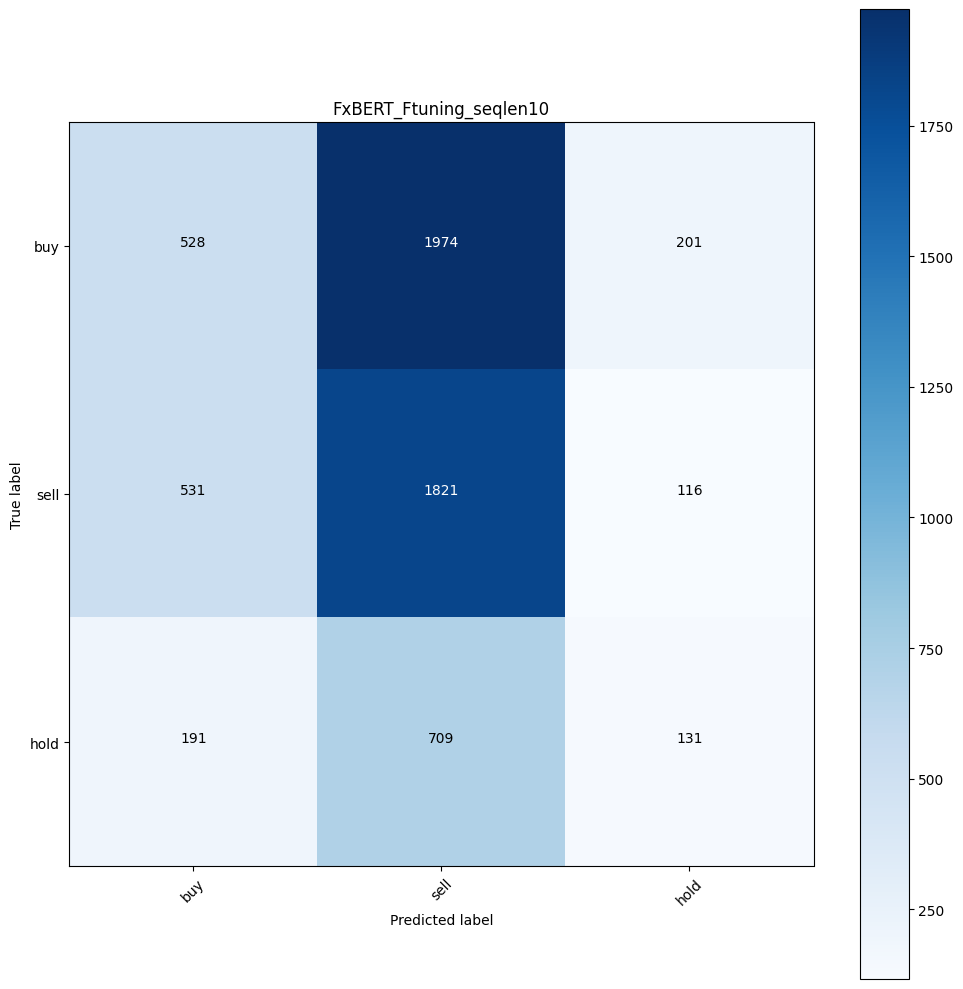

get result for seqlen 10 maxprice
FxBERT_Ftuning_seqlen10:
Mean Absolute Error: 0.16755122
Mean Absolute Percentage Error: 0.12862079
Mean Square Error: 0.05694000
Root Mean Square Error: 0.23862104

get result for seqlen 10 minprice
FxBERT_Ftuning_seqlen10:
Mean Absolute Error: 0.17889047
Mean Absolute Percentage Error: 0.13776110
Mean Square Error: 0.06534319
Root Mean Square Error: 0.25562314

total time spent 3.626274824142456


In [52]:
df_result, _ = model_evaluation(model, savepath_model, df_result, downstream_test_candleonly, seqlen=config.seqlen, modelname='FxBERT_Ftuning_seqlen'+str(config.seqlen))

df_result.to_csv(gd_result_folder+result_filename, index=False)

### 4.4 V2 bert extract feature

#### 4.4.1 create model - refer to 4.3.1

#### 4.4.2 Train model

In [53]:
savepath_model = \
    gd_mdl_folder+'FxBERT/ds_FxBERT_Feature_seqlen'+str(config.seqlen)+'_'+colab_filename.replace('.ipynb', '.h5')
savepath_model_weights = savepath_model.replace('.h5', '_weights.h5')
savepath_model_checkpoint = savepath_model_weights.replace('.h5', '_cp.h5')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(savepath_model_checkpoint, monitor="val_loss", verbose=0, mode="min",
                                                        save_best_only=True, save_weights_only=True, save_freq="epoch" )
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=config.patience, verbose=1, mode="min", restore_best_weights=True)

pretrained_FxBERT = tf.keras.Model(FxBERT.input, FxBERT.get_layer("encoder_"+str(config.NUM_LAYERS-1)+"/ffn_layernormalization").output)
pretrained_FxBERT.trainable = False

model = create_ds_FxBERT(pretrained_FxBERT, config.maxlen, config.seqlen)
#model.summary()

model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.00001, decay=1e-6),
    loss={
            "max_price": keras.losses.MeanSquaredError(),
            "min_price": keras.losses.MeanSquaredError(),
            "label_bhs": keras.losses.SparseCategoricalCrossentropy(),
        },
    metrics={
            "max_price": tf.keras.metrics.RootMeanSquaredError(),
            "min_price": tf.keras.metrics.RootMeanSquaredError(),
            "label_bhs": 'accuracy',
        }
    )
model.fit(
            x=downstream_train_candleonly[0], y=downstream_train_candleonly[1],
            epochs=config.EPOCH,
            validation_data=downstream_valid_candleonly,
            batch_size=config.BATCH_SIZE,
            callbacks=[checkpoint_cb, early_stop]
        )

model.save(savepath_model)
model.save_weights(savepath_model_weights)

Epoch 1/3
49/49 [==============================] - 6s 68ms/step - loss: 2.2948 - max_price_loss: 0.6107 - min_price_loss: 0.6015 - label_bhs_loss: 1.0826 - max_price_root_mean_squared_error: 0.7815 - min_price_root_mean_squared_error: 0.7756 - label_bhs_accuracy: 0.4311 - val_loss: 2.2367 - val_max_price_loss: 0.5673 - val_min_price_loss: 0.5627 - val_label_bhs_loss: 1.1067 - val_max_price_root_mean_squared_error: 0.7532 - val_min_price_root_mean_squared_error: 0.7501 - val_label_bhs_accuracy: 0.3596
Epoch 2/3
49/49 [==============================] - 3s 54ms/step - loss: 2.1306 - max_price_loss: 0.5261 - min_price_loss: 0.5594 - label_bhs_loss: 1.0451 - max_price_root_mean_squared_error: 0.7254 - min_price_root_mean_squared_error: 0.7479 - label_bhs_accuracy: 0.4595 - val_loss: 2.1996 - val_max_price_loss: 0.5631 - val_min_price_loss: 0.5379 - val_label_bhs_loss: 1.0986 - val_max_price_root_mean_squared_error: 0.7504 - val_min_price_root_mean_squared_error: 0.7334 - val_label_bhs_accur

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 4.4.3 Test result

194/194 [==============================] - 1s 4ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.4230    0.3933    0.4076      2703
        hold     0.2672    0.0902    0.1349      1031
        sell     0.3993    0.5405    0.4593      2468

    accuracy                         0.4015      6202
   macro avg     0.3632    0.3413    0.3339      6202
weighted avg     0.3877    0.4015    0.3828      6202



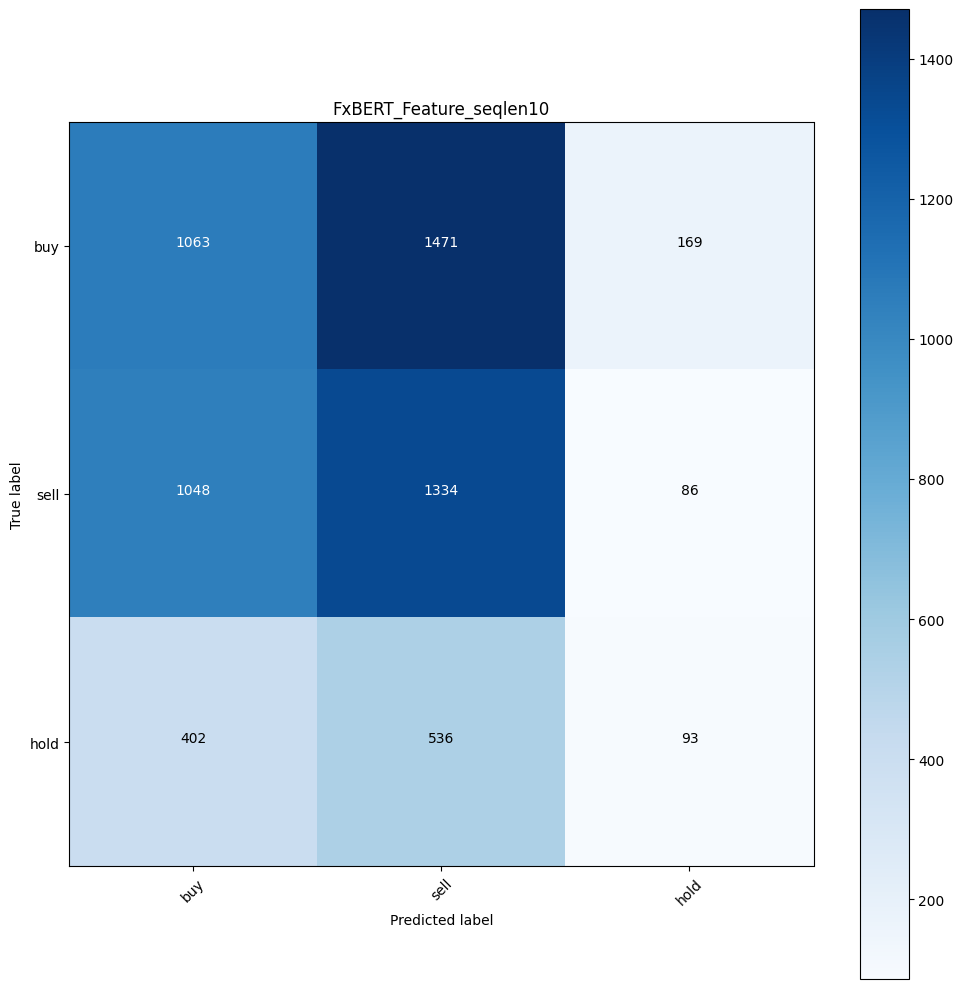

get result for seqlen 10 maxprice
FxBERT_Feature_seqlen10:
Mean Absolute Error: 0.17252509
Mean Absolute Percentage Error: 0.13242985
Mean Square Error: 0.06140946
Root Mean Square Error: 0.24780931

get result for seqlen 10 minprice
FxBERT_Feature_seqlen10:
Mean Absolute Error: 0.17685928
Mean Absolute Percentage Error: 0.13620096
Mean Square Error: 0.06451912
Root Mean Square Error: 0.25400615

total time spent 4.002388954162598


In [54]:
df_result, _ = model_evaluation(model, savepath_model, df_result, downstream_test_candleonly, config.seqlen, modelname='FxBERT_Feature_seqlen'+str(config.seqlen))

df_result.to_csv(gd_result_folder+result_filename, index=False)

In [55]:
del downstream_train_candleonly, downstream_valid_candleonly, downstream_test_candleonly
gc.collect()

10151

### 4.5 V3 bert feature + price 5

In [56]:
downstream_train_incl_price5 = generateSeq4Downstream(df_downstream_train, ds_type="train", input_type="incl_price5", seqlen=config.seqlen)
downstream_valid_incl_price5 = generateSeq4Downstream(df_downstream_valid, ds_type="valid", input_type="incl_price5", seqlen=config.seqlen)
downstream_test_incl_price5 = generateSeq4Downstream(df_downstream_test, ds_type="test", input_type="incl_price5", seqlen=config.seqlen)

#### 4.5.1 create model

In [57]:
def create_ds_FxBERT_price5(pretrained_FxBERT, maxlen, seqlen):
    input_wtoken_candle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_candle')
    input_wtoken_pos = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_pos')
    input_wtoken_die = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_die')
    input_wtoken_cle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_cle')
    input_wtoken_ule = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_ule')
    input_wtoken_lle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_lle')
    input_segment = layers.Input((maxlen,), dtype=tf.int64, name='segment_ids')
    input_price5 = layers.Input((seqlen,5), dtype=tf.float32, name='prices5_scaled')

    FxBERT_output = pretrained_FxBERT(inputs=[input_wtoken_candle, input_wtoken_pos, input_wtoken_die, input_wtoken_cle, \
                                    input_wtoken_ule, input_wtoken_lle, input_segment])
    FxBERT_output = layers.Flatten()(FxBERT_output)

    price5_output = layers.LSTM(config.EMBED_DIM, activation="relu", return_sequences=False, name='price5_scaled_LSTM')(input_price5)

    combined_output = layers.Concatenate()([FxBERT_output, price5_output])

    normalized_output = layers.LayerNormalization(epsilon=1e-6)(combined_output)
    regularization_layer = layers.LeakyReLU(alpha=0.1)(normalized_output)
    dropout_layer = layers.Dropout(0.1)(regularization_layer)

    x1 = layers.Dense(1024, activation="relu")(dropout_layer)
    x1 = layers.Dense(1024, activation="relu")(x1)
    x1 = layers.Dense(512, activation="relu")(x1)
    output_max_price = layers.Dense(1, activation="linear", name='max_price')(x1)

    x2 = layers.Dense(1024, activation="relu")(dropout_layer)
    x2 = layers.Dense(1024, activation="relu")(x2)
    x2 = layers.Dense(512, activation="relu")(x2)
    output_min_price = layers.Dense(1, activation="linear", name='min_price')(x2)

    x3 = layers.Dense(1024, activation="relu")(dropout_layer)
    x3 = layers.Dense(1024, activation="relu")(x3)
    x3 = layers.Dense(512, activation="relu")(x3)
    output_label_bhs = layers.Dense(3, activation="softmax", name='label_bhs')(x3)

    model = keras.Model(
            inputs=[input_wtoken_candle, input_wtoken_pos, input_wtoken_die, input_wtoken_cle,
                                    input_wtoken_ule, input_wtoken_lle, input_segment, input_price5],
            outputs=[output_max_price, output_min_price, output_label_bhs])

    return model

#### 4.5.2 Train model

In [58]:
savepath_model = \
    gd_mdl_folder+'FxBERT/ds_FxBERT_Feature_price5_seqlen'+str(config.seqlen)+'_'+colab_filename.replace('.ipynb', '.h5')
savepath_model_weights = savepath_model.replace('.h5', '_weights.h5')
savepath_model_checkpoint = savepath_model_weights.replace('.h5', '_cp.h5')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(savepath_model_checkpoint, monitor="val_loss", verbose=0, mode="min",
                                                        save_best_only=True, save_weights_only=True, save_freq="epoch" )
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=config.patience, verbose=1, mode="min", restore_best_weights=True)

pretrained_FxBERT = tf.keras.Model(FxBERT.input, FxBERT.get_layer("encoder_"+str(config.NUM_LAYERS-1)+"/ffn_layernormalization").output)
pretrained_FxBERT.trainable = False

model = create_ds_FxBERT_price5(pretrained_FxBERT, config.maxlen, config.seqlen)
#model.summary()

model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.00001, decay=1e-6),
    loss={
            "max_price": keras.losses.MeanSquaredError(),
            "min_price": keras.losses.MeanSquaredError(),
            "label_bhs": keras.losses.SparseCategoricalCrossentropy(),
        },
    metrics={
            "max_price": tf.keras.metrics.RootMeanSquaredError(),
            "min_price": tf.keras.metrics.RootMeanSquaredError(),
            "label_bhs": 'accuracy',
        }
    )
model.fit(
            x=downstream_train_incl_price5[0], y=downstream_train_incl_price5[1],
            epochs=config.EPOCH,
            validation_data=downstream_valid_incl_price5,
            batch_size=config.BATCH_SIZE,
            callbacks=[checkpoint_cb, early_stop]
        )

model.save(savepath_model)
model.save_weights(savepath_model_weights)

Epoch 1/3
49/49 [==============================] - 7s 74ms/step - loss: 2.2848 - max_price_loss: 0.6084 - min_price_loss: 0.6013 - label_bhs_loss: 1.0751 - max_price_root_mean_squared_error: 0.7800 - min_price_root_mean_squared_error: 0.7754 - label_bhs_accuracy: 0.4313 - val_loss: 2.2731 - val_max_price_loss: 0.5721 - val_min_price_loss: 0.5545 - val_label_bhs_loss: 1.1465 - val_max_price_root_mean_squared_error: 0.7564 - val_min_price_root_mean_squared_error: 0.7446 - val_label_bhs_accuracy: 0.3402
Epoch 2/3
49/49 [==============================] - 3s 59ms/step - loss: 2.1276 - max_price_loss: 0.5239 - min_price_loss: 0.5567 - label_bhs_loss: 1.0470 - max_price_root_mean_squared_error: 0.7238 - min_price_root_mean_squared_error: 0.7461 - label_bhs_accuracy: 0.4580 - val_loss: 2.1945 - val_max_price_loss: 0.5520 - val_min_price_loss: 0.5370 - val_label_bhs_loss: 1.1055 - val_max_price_root_mean_squared_error: 0.7430 - val_min_price_root_mean_squared_error: 0.7328 - val_label_bhs_accur

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 4.5.3 Test result

194/194 [==============================] - 1s 5ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.4281    0.4547    0.4410      2703
        hold     0.2989    0.1096    0.1604      1031
        sell     0.3965    0.4745    0.4320      2468

    accuracy                         0.4052      6202
   macro avg     0.3745    0.3463    0.3445      6202
weighted avg     0.3941    0.4052    0.3908      6202



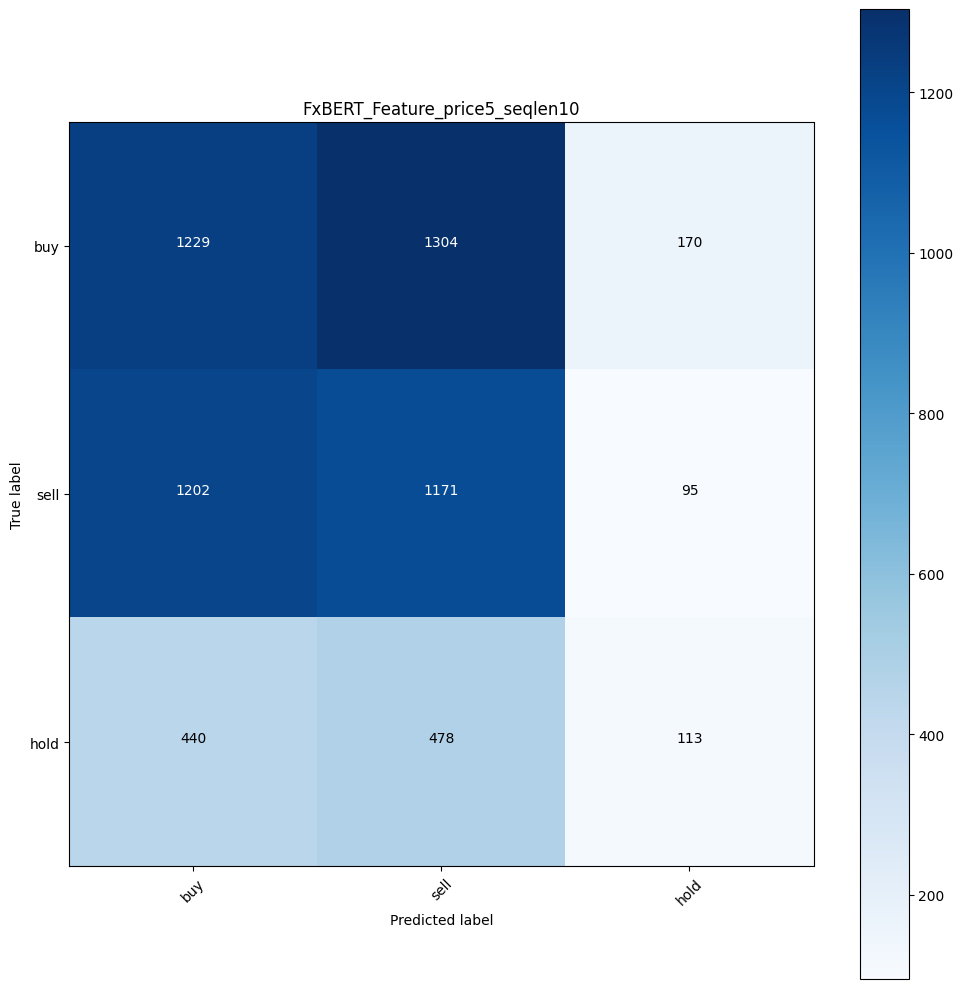

get result for seqlen 10 maxprice
FxBERT_Feature_price5_seqlen10:
Mean Absolute Error: 0.17646110
Mean Absolute Percentage Error: 0.13550016
Mean Square Error: 0.06378591
Root Mean Square Error: 0.25255872

get result for seqlen 10 minprice
FxBERT_Feature_price5_seqlen10:
Mean Absolute Error: 0.17018071
Mean Absolute Percentage Error: 0.13103835
Mean Square Error: 0.06291370
Root Mean Square Error: 0.25082603

total time spent 4.687232971191406


In [59]:
df_result, _ = model_evaluation(model, savepath_model, df_result, downstream_test_incl_price5, config.seqlen, modelname='FxBERT_Feature_price5_seqlen'+str(config.seqlen))

df_result.to_csv(gd_result_folder+result_filename, index=False)

### 4.6 V4 bert fine-tuning feature, price5

#### 4.6.1 create model - refer to 4.5.1

#### 4.6.2 Train model

In [60]:
savepath_model = \
    gd_mdl_folder+'FxBERT/ds_FxBERT_Ftuning_price5_seqlen'+str(config.seqlen)+'_'+colab_filename.replace('.ipynb', '.h5')
savepath_model_weights = savepath_model.replace('.h5', '_weights.h5')
savepath_model_checkpoint = savepath_model_weights.replace('.h5', '_cp.h5')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(savepath_model_checkpoint, monitor="val_loss", verbose=0, mode="min",
                                                        save_best_only=True, save_weights_only=True, save_freq="epoch" )
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=config.patience, verbose=1, mode="min", restore_best_weights=True)

pretrained_FxBERT = tf.keras.Model(FxBERT.input, FxBERT.get_layer("encoder_"+str(config.NUM_LAYERS-1)+"/ffn_layernormalization").output)
pretrained_FxBERT.trainable = True

model = create_ds_FxBERT_price5(pretrained_FxBERT, config.maxlen, config.seqlen)
#model.summary()

model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.00001, decay=1e-6),
    loss={
            "max_price": keras.losses.MeanSquaredError(),
            "min_price": keras.losses.MeanSquaredError(),
            "label_bhs": keras.losses.SparseCategoricalCrossentropy(),
        },
    metrics={
            "max_price": tf.keras.metrics.RootMeanSquaredError(),
            "min_price": tf.keras.metrics.RootMeanSquaredError(),
            "label_bhs": 'accuracy',
        }
    )
model.fit(
            x=downstream_train_incl_price5[0], y=downstream_train_incl_price5[1],
            epochs=config.EPOCH,
            validation_data=downstream_valid_incl_price5,
            batch_size=config.BATCH_SIZE,
            callbacks=[checkpoint_cb, early_stop]
        )

model.save(savepath_model)
model.save_weights(savepath_model_weights)

Epoch 1/3
49/49 [==============================] - 9s 103ms/step - loss: 2.4684 - max_price_loss: 0.7914 - min_price_loss: 0.6014 - label_bhs_loss: 1.0756 - max_price_root_mean_squared_error: 0.8896 - min_price_root_mean_squared_error: 0.7755 - label_bhs_accuracy: 0.4310 - val_loss: 2.2559 - val_max_price_loss: 0.5788 - val_min_price_loss: 0.5554 - val_label_bhs_loss: 1.1217 - val_max_price_root_mean_squared_error: 0.7608 - val_min_price_root_mean_squared_error: 0.7452 - val_label_bhs_accuracy: 0.3609
Epoch 2/3
49/49 [==============================] - 4s 85ms/step - loss: 2.1330 - max_price_loss: 0.5316 - min_price_loss: 0.5568 - label_bhs_loss: 1.0446 - max_price_root_mean_squared_error: 0.7291 - min_price_root_mean_squared_error: 0.7462 - label_bhs_accuracy: 0.4598 - val_loss: 2.1985 - val_max_price_loss: 0.5530 - val_min_price_loss: 0.5332 - val_label_bhs_loss: 1.1123 - val_max_price_root_mean_squared_error: 0.7436 - val_min_price_root_mean_squared_error: 0.7302 - val_label_bhs_accu

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 4.6.3 Test result

194/194 [==============================] - 1s 5ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.4309    0.7336    0.5429      2703
        hold     0.2893    0.1339    0.1830      1031
        sell     0.3980    0.1811    0.2490      2468

    accuracy                         0.4141      6202
   macro avg     0.3727    0.3495    0.3250      6202
weighted avg     0.3943    0.4141    0.3661      6202



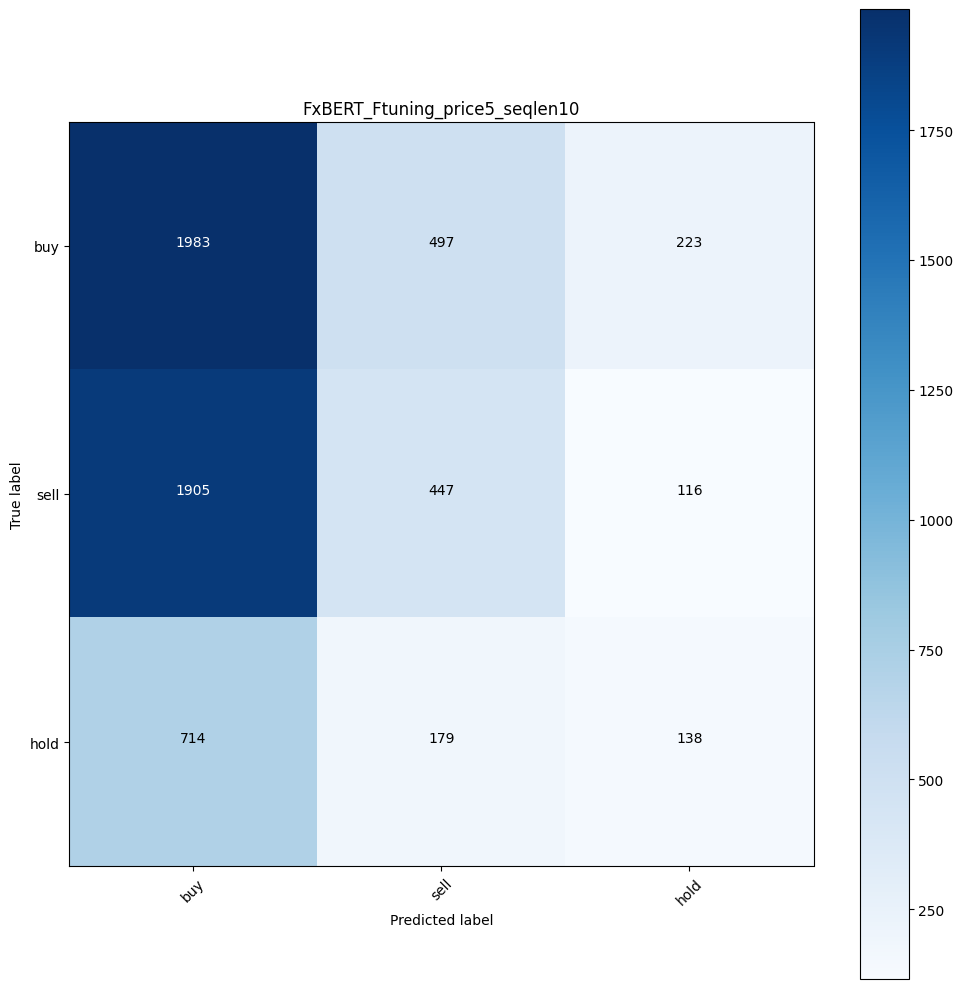

get result for seqlen 10 maxprice
FxBERT_Ftuning_price5_seqlen10:
Mean Absolute Error: 0.17376629
Mean Absolute Percentage Error: 0.13345384
Mean Square Error: 0.05944326
Root Mean Square Error: 0.24380988

get result for seqlen 10 minprice
FxBERT_Ftuning_price5_seqlen10:
Mean Absolute Error: 0.17652818
Mean Absolute Percentage Error: 0.13593327
Mean Square Error: 0.06456639
Root Mean Square Error: 0.25409917

total time spent 4.756909608840942


In [61]:
df_result, _ = model_evaluation(model, savepath_model, df_result, downstream_test_incl_price5, config.seqlen, modelname='FxBERT_Ftuning_price5_seqlen'+str(config.seqlen))

df_result.to_csv(gd_result_folder+result_filename, index=False)

In [62]:
del downstream_train_incl_price5, downstream_valid_incl_price5, downstream_test_incl_price5
gc.collect()

29060

### 4.7 V5 bert extract feature, price5, TA

In [63]:
downstream_train_incl_price5_ta = generateSeq4Downstream(df_downstream_train, ds_type="train", input_type="incl_price5_ta", seqlen=config.seqlen)
downstream_valid_incl_price5_ta = generateSeq4Downstream(df_downstream_valid, ds_type="valid", input_type="incl_price5_ta", seqlen=config.seqlen)
downstream_test_incl_price5_ta = generateSeq4Downstream(df_downstream_test, ds_type="test", input_type="incl_price5_ta", seqlen=config.seqlen)

#### 4.7.1 create model

In [64]:
def create_ds_FxBERT_price5_TA(pretrained_FxBERT, maxlen, seqlen):
    input_wtoken_candle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_candle')
    input_wtoken_pos = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_pos')
    input_wtoken_die = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_die')
    input_wtoken_cle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_cle')
    input_wtoken_ule = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_ule')
    input_wtoken_lle = layers.Input((maxlen,), dtype=tf.int64, name='input_ids_lle')
    input_segment = layers.Input((maxlen,), dtype=tf.int64, name='segment_ids')
    input_price5 = layers.Input((seqlen,5), dtype=tf.float32, name='prices5_scaled')
    input_TA = layers.Input((seqlen, 15), dtype=tf.float32, name='ta_scaled')

    FxBERT_output = pretrained_FxBERT(inputs=[input_wtoken_candle, input_wtoken_pos, input_wtoken_die, input_wtoken_cle, \
                                    input_wtoken_ule, input_wtoken_lle, input_segment])
    FxBERT_output = layers.Flatten()(FxBERT_output)

    price5_output = layers.LSTM(config.EMBED_DIM, activation="relu", return_sequences=False, name='price5_scaled_LSTM')(input_price5)
    TA_output = layers.LSTM(config.EMBED_DIM, activation="relu", return_sequences=False, name='ta_scaled_LSTM')(input_TA)

    combined_output = layers.Concatenate()([FxBERT_output, price5_output, TA_output])

    normalized_output = layers.LayerNormalization(epsilon=1e-6)(combined_output)
    regularization_layer = layers.LeakyReLU(alpha=0.1)(normalized_output)
    dropout_layer = layers.Dropout(0.1)(regularization_layer)

    x1 = layers.Dense(1024, activation="relu")(dropout_layer)
    x1 = layers.Dense(1024, activation="relu")(x1)
    x1 = layers.Dense(512, activation="relu")(x1)
    output_max_price = layers.Dense(1, activation="linear", name='max_price')(x1)

    x2 = layers.Dense(1024, activation="relu")(dropout_layer)
    x2 = layers.Dense(1024, activation="relu")(x2)
    x2 = layers.Dense(512, activation="relu")(x2)
    output_min_price = layers.Dense(1, activation="linear", name='min_price')(x2)

    x3 = layers.Dense(1024, activation="relu")(dropout_layer)
    x3 = layers.Dense(1024, activation="relu")(x3)
    x3 = layers.Dense(512, activation="relu")(x3)
    output_label_bhs = layers.Dense(3, activation="softmax", name='label_bhs')(x3)

    model = keras.Model(
            inputs=[input_wtoken_candle, input_wtoken_pos, input_wtoken_die, input_wtoken_cle,
                                    input_wtoken_ule, input_wtoken_lle, input_segment, input_price5, input_TA],
            outputs=[output_max_price, output_min_price, output_label_bhs])

    return model

#### 4.7.2 Train model

In [65]:
savepath_model = \
    gd_mdl_folder+'FxBERT/ds_FxBERT_Feature_price5_TA_seqlen'+str(config.seqlen)+'_'+colab_filename.replace('.ipynb', '.h5')
savepath_model_weights = savepath_model.replace('.h5', '_weights.h5')
savepath_model_checkpoint = savepath_model_weights.replace('.h5', '_cp.h5')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(savepath_model_checkpoint, monitor="val_loss", verbose=0, mode="min",
                                                        save_best_only=True, save_weights_only=True, save_freq="epoch" )
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=config.patience, verbose=1, mode="min", restore_best_weights=True)

pretrained_FxBERT = tf.keras.Model(FxBERT.input, FxBERT.get_layer("encoder_"+str(config.NUM_LAYERS-1)+"/ffn_layernormalization").output)
pretrained_FxBERT.trainable = False

model = create_ds_FxBERT_price5_TA(pretrained_FxBERT, config.maxlen, config.seqlen)
#model.summary()

model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.00001, decay=1e-6),
    loss={
            "max_price": keras.losses.MeanSquaredError(),
            "min_price": keras.losses.MeanSquaredError(),
            "label_bhs": keras.losses.SparseCategoricalCrossentropy(),
        },
    metrics={
            "max_price": tf.keras.metrics.RootMeanSquaredError(),
            "min_price": tf.keras.metrics.RootMeanSquaredError(),
            "label_bhs": 'accuracy',
        }
    )
model.fit(
            x=downstream_train_incl_price5_ta[0], y=downstream_train_incl_price5_ta[1],
            epochs=config.EPOCH,
            validation_data=downstream_valid_incl_price5_ta,
            batch_size=config.BATCH_SIZE,
            callbacks=[checkpoint_cb, early_stop]
        )

model.save(savepath_model)
model.save_weights(savepath_model_weights)

Epoch 1/3
49/49 [==============================] - 8s 81ms/step - loss: 2.2527 - max_price_loss: 0.5761 - min_price_loss: 0.6075 - label_bhs_loss: 1.0691 - max_price_root_mean_squared_error: 0.7590 - min_price_root_mean_squared_error: 0.7794 - label_bhs_accuracy: 0.4385 - val_loss: 2.2412 - val_max_price_loss: 0.5798 - val_min_price_loss: 0.5561 - val_label_bhs_loss: 1.1053 - val_max_price_root_mean_squared_error: 0.7614 - val_min_price_root_mean_squared_error: 0.7457 - val_label_bhs_accuracy: 0.3789
Epoch 2/3
49/49 [==============================] - 3s 63ms/step - loss: 2.1149 - max_price_loss: 0.5117 - min_price_loss: 0.5588 - label_bhs_loss: 1.0445 - max_price_root_mean_squared_error: 0.7153 - min_price_root_mean_squared_error: 0.7475 - label_bhs_accuracy: 0.4617 - val_loss: 2.2029 - val_max_price_loss: 0.5657 - val_min_price_loss: 0.5374 - val_label_bhs_loss: 1.0998 - val_max_price_root_mean_squared_error: 0.7521 - val_min_price_root_mean_squared_error: 0.7331 - val_label_bhs_accur

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 4.7.3 Test result

194/194 [==============================] - 1s 6ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.4326    0.6578    0.5219      2703
        hold     0.2496    0.1707    0.2028      1031
        sell     0.4081    0.2293    0.2936      2468

    accuracy                         0.4063      6202
   macro avg     0.3634    0.3526    0.3395      6202
weighted avg     0.3924    0.4063    0.3780      6202



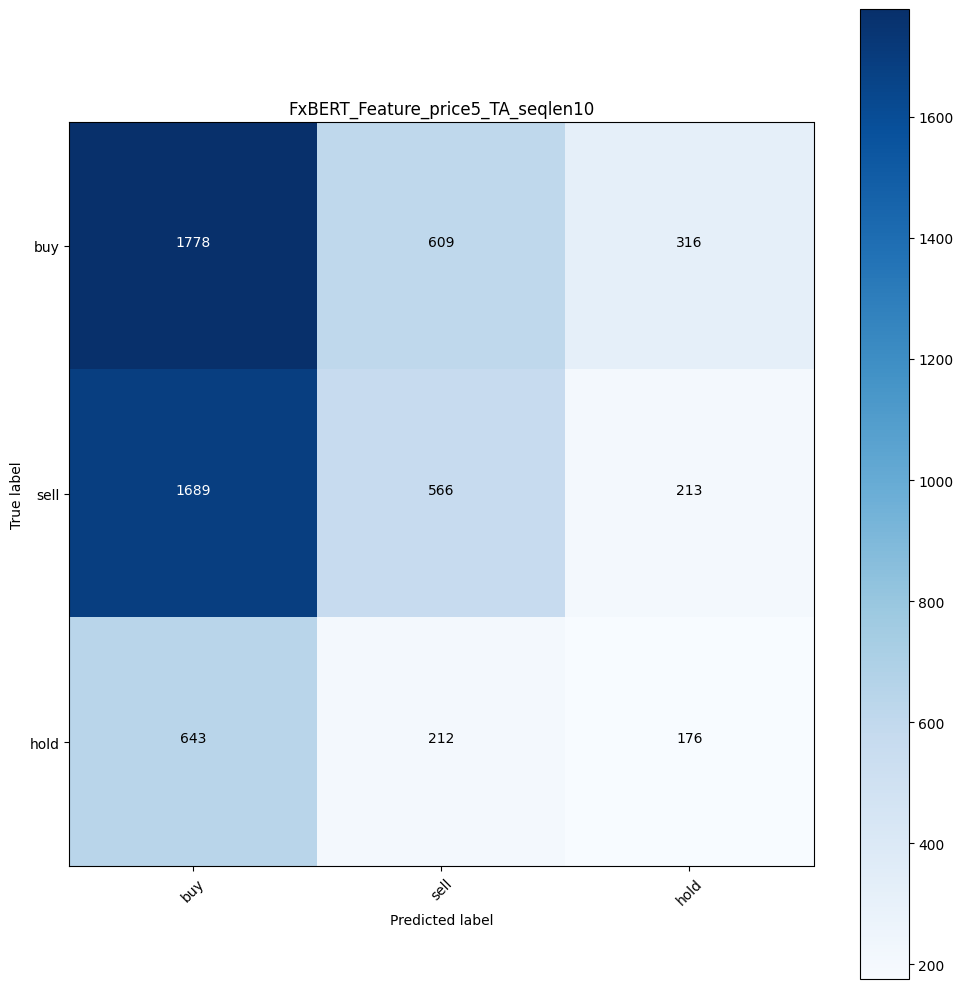

get result for seqlen 10 maxprice
FxBERT_Feature_price5_TA_seqlen10:
Mean Absolute Error: 0.16893059
Mean Absolute Percentage Error: 0.12968527
Mean Square Error: 0.05924486
Root Mean Square Error: 0.24340266

get result for seqlen 10 minprice
FxBERT_Feature_price5_TA_seqlen10:
Mean Absolute Error: 0.17085130
Mean Absolute Percentage Error: 0.13148460
Mean Square Error: 0.06248005
Root Mean Square Error: 0.24996010

total time spent 5.604613780975342


In [66]:
df_result, _ = model_evaluation(model, savepath_model, df_result, downstream_test_incl_price5_ta, config.seqlen, modelname='FxBERT_Feature_price5_TA_seqlen'+str(config.seqlen), )

df_result.to_csv(gd_result_folder+result_filename, index=False)

### 4.8 V6 bert fine-tuning, price5, TA

#### 4.8.1 create model - refer to 4.7.1

#### 4.8.2 Train model

In [67]:
savepath_model = \
    gd_mdl_folder+'FxBERT/ds_FxBERT_Ftuning_price5_TA_seqlen'+str(config.seqlen)+'_'+colab_filename.replace('.ipynb', '.h5')
savepath_model_weights = savepath_model.replace('.h5', '_weights.h5')
savepath_model_checkpoint = savepath_model_weights.replace('.h5', '_cp.h5')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(savepath_model_checkpoint, monitor="val_loss", verbose=0, mode="min",
                                                        save_best_only=True, save_weights_only=True, save_freq="epoch" )
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=config.patience, verbose=1, mode="min", restore_best_weights=True)

pretrained_FxBERT = tf.keras.Model(FxBERT.input, FxBERT.get_layer("encoder_"+str(config.NUM_LAYERS-1)+"/ffn_layernormalization").output)
pretrained_FxBERT.trainable = True

model = create_ds_FxBERT_price5_TA(pretrained_FxBERT, config.maxlen, config.seqlen)
#model.summary()

model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.00001, decay=1e-6),
    loss={
            "max_price": keras.losses.MeanSquaredError(),
            "min_price": keras.losses.MeanSquaredError(),
            "label_bhs": keras.losses.SparseCategoricalCrossentropy(),
        },
    metrics={
            "max_price": tf.keras.metrics.RootMeanSquaredError(),
            "min_price": tf.keras.metrics.RootMeanSquaredError(),
            "label_bhs": 'accuracy',
        }
    )
model.fit(
            x=downstream_train_incl_price5_ta[0], y=downstream_train_incl_price5_ta[1],
            epochs=config.EPOCH,
            validation_data=downstream_valid_incl_price5_ta,
            batch_size=config.BATCH_SIZE,
            callbacks=[checkpoint_cb, early_stop]
        )

model.save(savepath_model)
model.save_weights(savepath_model_weights)

Epoch 1/3
49/49 [==============================] - 10s 111ms/step - loss: 2.2496 - max_price_loss: 0.5857 - min_price_loss: 0.5886 - label_bhs_loss: 1.0754 - max_price_root_mean_squared_error: 0.7653 - min_price_root_mean_squared_error: 0.7672 - label_bhs_accuracy: 0.4323 - val_loss: 2.2093 - val_max_price_loss: 0.5642 - val_min_price_loss: 0.5415 - val_label_bhs_loss: 1.1037 - val_max_price_root_mean_squared_error: 0.7511 - val_min_price_root_mean_squared_error: 0.7358 - val_label_bhs_accuracy: 0.3715
Epoch 2/3
49/49 [==============================] - 4s 76ms/step - loss: 2.0991 - max_price_loss: 0.5117 - min_price_loss: 0.5458 - label_bhs_loss: 1.0416 - max_price_root_mean_squared_error: 0.7153 - min_price_root_mean_squared_error: 0.7388 - label_bhs_accuracy: 0.4641 - val_loss: 2.2117 - val_max_price_loss: 0.5778 - val_min_price_loss: 0.5303 - val_label_bhs_loss: 1.1036 - val_max_price_root_mean_squared_error: 0.7601 - val_min_price_root_mean_squared_error: 0.7282 - val_label_bhs_acc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 4.8.3 Test result

194/194 [==============================] - 1s 6ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.4302    0.6382    0.5139      2703
        hold     0.2957    0.1319    0.1824      1031
        sell     0.3909    0.2743    0.3224      2468

    accuracy                         0.4092      6202
   macro avg     0.3722    0.3481    0.3396      6202
weighted avg     0.3922    0.4092    0.3826      6202



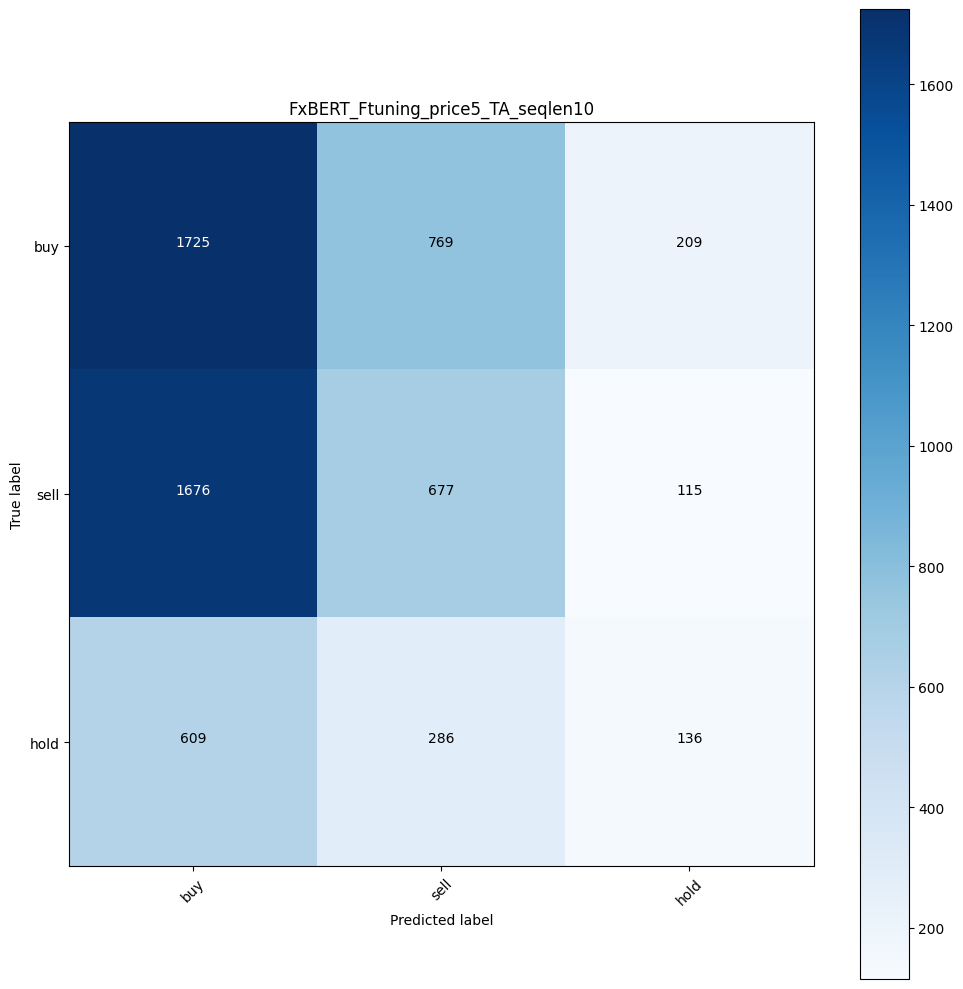

get result for seqlen 10 maxprice
FxBERT_Ftuning_price5_TA_seqlen10:
Mean Absolute Error: 0.16986441
Mean Absolute Percentage Error: 0.13043699
Mean Square Error: 0.06009889
Root Mean Square Error: 0.24515074

get result for seqlen 10 minprice
FxBERT_Ftuning_price5_TA_seqlen10:
Mean Absolute Error: 0.16879381
Mean Absolute Percentage Error: 0.12993366
Mean Square Error: 0.06107022
Root Mean Square Error: 0.24712389

total time spent 5.627118825912476


In [68]:
df_result, _ = model_evaluation(model, savepath_model, df_result, downstream_test_incl_price5_ta, config.seqlen, modelname='FxBERT_Ftuning_price5_TA_seqlen'+str(config.seqlen))

df_result.to_csv(gd_result_folder+result_filename, index=False)

In [69]:
del downstream_train_incl_price5_ta, downstream_valid_incl_price5_ta, downstream_test_incl_price5_ta
gc.collect()

8745